# Entrenamiento de un LLM

En esta sección se implementará el código necesario para entrenar el modelo GPT.
Para ello se construirá un bucle de entrenamiento sencillo, para mantener código conciso y legible.

![Texto alternativo](./imgs/5.11.png)

Un  bucle  de  entrenamiento  típico  para  el  entrenamiento  de  redes  neuronales  profundas  en  PyTorch  consta  de  varios  pasos  que  iteran  sobre  los  lotes  del  conjunto  de  entrenamiento  durante  varias  épocas.  En  cada  bucle,  se calcula  la  pérdida  de  cada  lote  del  conjunto  de  entrenamiento  para  determinar  los  gradientes  de  pérdida,  que  utilizamos  para  actualizar  los  pesos  del  modelo  de  forma  que la pédida del conjunto de entreneamiento se minimiza.

La figura muestra  un  flujo  de  trabajo  típico  de  entrenamiento  de  redes  neuronales  con  PyTorch,  el  cual  utilizamos  para  entrenar  un  LLM.  Describe  ocho  pasos,  comenzando  con  la  iteración  sobre  cada  época,  el  procesamiento  de  lotes,  el  restablecimiento  y  cálculo  de  gradientes,  la  actualización  de  pesos  y,  finalmente,  con  la  monitorización  de  pasos  como  la  impresión  de  pérdidas  y  la  generación  de  muestras  de  texto.  

In [24]:
import sys
import os

# Obtiene la ruta de la carpeta principal del proyecto (subiendo un nivel desde seccion05)
ruta_proyecto_principal = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Añade esta ruta a la lista de lugares donde Python busca módulos
if ruta_proyecto_principal not in sys.path:
    sys.path.append(ruta_proyecto_principal)

In [25]:
import torch
from calcTextValLoss import calc_loss_batch
from calcTextValLoss import calc_loss_loader

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):

    train_losses, val_losses, track_tokens_seen = [], [], [] #inicializar listas para rastrear pérdidas y tokens vistos
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs): #inicializar el ciclo de entrenamiento principal
        model.train()
        
        for input_batch, target_batch in train_loader:
            #input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            optimizer.zero_grad() #restablecer los gradientes de pérdida de la iteración del lote anterior
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() #calcular los gradientes de pérdida
            optimizer.step() #actualizar los pesos usando descenso de gradiente
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:                     
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(                                #imprimir ejemplo de texto
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen
                


La  función  evaluation_model  calcula  la  pérdida  en  el  conjunto  de  entrenamiento  y  validación  mientras  garantiza  que  el  modelo  esté  en  modo  de  evaluación  con  seguimiento  de  gradiente  y  abandono  deshabilitados  al  calcular  la  pérdida  en  los  conjuntos  de  entrenamiento  y  validación.

In [26]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

Similar  a  "evaluation_model",  la  función  "generate_and_print_sample"  es  una  función  práctica  que  utilizamos  para  monitorizar  si  el  modelo  mejora  durante  el  entrenamiento.  En  particular,  la  función  "generate_and_print_sample"  toma  un  fragmento  de  texto  (contexto_inicio)  como  entrada,  lo  convierte  en  identificadores  de  token  y  lo  envía  al  LLM  para  generar  una  muestra  de  texto  mediante  la  función  "generar_texto_simple"  que  se utilizó  anteriormente:

In [27]:
from seccion04_ImplementacionGPTGeneracionTexto.generateTextSimple import generate_text_simple
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  
    model.train()



Mientras  que  la  función  evaluation_model  da  una  estimación  numérica  del  progreso  de  entrenamiento  del  modelo,  esta  función  de  texto  generate_and_print_sample  proporciona  un  ejemplo  de  texto  concreto  generado  por  el  modelo  para  juzgar  sus  capacidades  durante  el  entrenamiento.

### ADAMW

Los  optimizadores  Adam  son  una  opción  popular  para  entrenar  redes  neuronales  profundas.  Sin  embargo,  en el ciclo  de  entrenamiento, se opta  por  el  optimizador  AdamW .  AdamW  es  una  variante  de  Adam  que  mejora  el  enfoque  de  decaimiento  de  pesos,  cuyo  objetivo  es  minimizar  la  complejidad  del  modelo  y  evitar  el  sobreajuste  al  penalizar  pesos  mayores.  Este  ajuste  permite  a  AdamW  lograr  una  regularización  más  efectiva  y  una  mejor  generalización,  por  lo  que  se  utiliza  
frecuentemente  en  el  entrenamiento  de  LLM.

In [28]:
file_path = "../txt/The_Verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

tokenizer = tiktoken.get_encoding("gpt2")

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[: split_idx]
val_data = text_data[split_idx :]

Characters: 20483
Tokens: 5147


In [29]:
from seccion04_ImplementacionGPTGeneracionTexto.gptModel import GPTModel
from seccion04_ImplementacionGPTGeneracionTexto.gptConfig124M import GPT_CONFIG_124M
from seccion02_TrabajarDatosTexto.dataloader_v1 import create_dataloader_v1
GPT_CONFIG_124M["context_length"] = 256


torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) #el método parameters() devuelve todos los pesos entrenables del modelo
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.063, Val loss 9.945
Ep 1 (Step 000005): Train loss 8.156, Val loss 8.334
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.556, Val loss 7.037
Ep 2 (Step 000015): Train loss 5.927, Val loss 6.580
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.824, Val loss 6.464
Ep 3 (Step 000025): Train loss 5.381, Val loss 6.365
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.598, Val loss 6.250
Ep 4 (Step 000035): Train loss 5.028, Val loss 6.267
Every effort moves you of the picture.      "I                "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.076, Val loss 6.136
Every effort moves you know the                          "Oh, and the fa

Como  se puede observar,  según  los  resultados  impresos  durante  el  entrenamiento,  la  pérdida  de  entrenamiento  mejora  drásticamente,  comenzando  con  un  valor  de  9,558  y  convergiendo  a  0,762.  Las  habilidades  lingüísticas  del  modelo  han  mejorado  considerablemente.  Al  principio,  el  modelo  solo  puede  añadir  comas  al  contexto  inicial  ("Every  strive  moves  you,,,,,,,,,,,,")  o  repetir  la  palabra  "and".  Al  final  del  entrenamiento,  puede  generar  texto  gramaticalmente  correcto.

Al  igual  que  con  la  pérdida  del  conjunto  de  entrenamiento, se observa que  la  pérdida  de  validación  comienza  alta y  disminuye  durante  el  entrenamiento.  Sin  embargo,  nunca  llega  a  ser  tan  pequeña  como  la  pérdida  del  conjunto  de  entrenamiento. 

Gráfico  simple  que  muestre  las  pérdidas  de  los  conjuntos  de  entrenamiento  y  validación  una  al  lado  de  la  otra

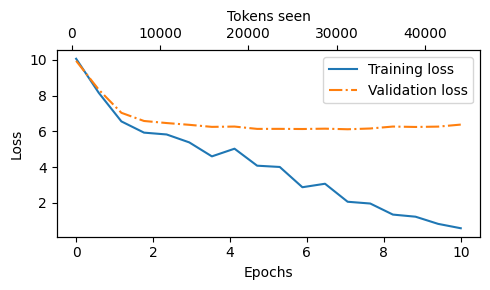

In [ ]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()                                             
    ax2.plot(tokens_seen, train_losses, alpha=0)    #gráfico invisible apra alinear marcas              
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Tanto  las  pérdidas  de  entrenamiento  como  las  de  validación  comienzan  a  mejorar  en  la  primera  época.  Sin  embargo,  las  pérdidas  comienzan  a  divergir  después  de  la  segunda  época.  Esta  divergencia,  y  el  hecho  de  que  la  pérdida  de  validación  sea  mucho  mayor  que  la  de  entrenamiento,  indican  que  el  modelo  se  está  sobreajustando  a  los  datos  de  entrenamiento.  El modelo memoriza los datos de entrenamiento.

Esta  memorización  es  previsible,  ya  que  se está trabajando  con  un  conjunto  de  datos  de  entrenamiento  muy  pequeño  y se entrena el  modelo  para  múltiples  épocas.  Normalmente,  es  común  entrenar  un  modelo  con  un  conjunto  de  datos  mucho  mayor  para  una  sola  época.

![Texto alternativo](./imgs/5.12.png)

La  siguiente  sección  cubrirá  las  estrategias  de  generación  de  texto  para  LLM  para  reducir  la  memorización  de  datos  de  entrenamiento  y  aumentar  la  originalidad  del  texto  generado  por  LLM .

[Estrategias de decodificación para controlar la aleatoriedad](./3_estrategias_decodificacion_control_aleatoriedad.ipynb)